In [1]:
import sys
sys.path.append('C:\\Users\\henri\\source\\repos\\mozubi_tools\\_Analysis\\Correlation')
sys.path.append('C:\\Users\\henri\\source\\repos\\mozubi_tools\\')
import corr_functions as cfnc
import _Data.PredictionDataBase.DBFunctions as db

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns
sns.set(style="whitegrid",palette=sns.color_palette("Paired",9))

In [2]:
def getHKWdf(yearfrom, yearto=None):
    if yearto == None:
        yearto = yearfrom

    df = db.GetALL().loc[yearfrom:yearto]
    hkws = [col for col in df.columns if "HKW".lower() in col.lower()]
    HKW = pd.DataFrame(df[hkws])
    HKW['Hkw']= HKW.sum(axis=1)
    HKW = pd.DataFrame(HKW.pop('Hkw'))
    df = HKW.join(db.GetDAPrices()).join(db.GetIDPrices()).join(db.GetLoad()).join(db.GetWxSet('Temperature')).loc[yearfrom:yearto]
    df = cfnc.AppendTimeIndexes(df)
    df = df[['Hkw','DAPrice','Temperature','LoadVolume','QuarterHour','Hour','WeekDay','DayOfYear','IDPrice']]
    df = df.interpolate(method='pchip')
    df['LastDay'] = df['Hkw'].shift(96)
    temperature =[]
    HKW = []
    return df.dropna()

In [3]:
def plotCorr(df):
    fig, ax = plt.subplots(figsize=(10,7))
    sns.heatmap(df.corr(), annot=False)
    plt.show()
def getRelevantFeatures(df):
    return cfnc.GetRelevantFeaturesFromCorr(df.corr(),target=abs(df.corr().Hkw),corrTargetValue=0.25)

In [4]:
def getTrainTestSets(df_X,df_y, train_test_split=0.7):
    y = df_y.values
    X = df_X.values
    split = int(len(X)*train_test_split)
    X_train, X_test = X[0:split], X[split:]
    y_train, y_test = y[0:split], y[split:]
    return X_train,X_test,y_train,y_test

def scaleDfMinMax(dfIn):
    for col in df.columns:
        # if col != 'Temperature':
            scaler = MinMaxScaler()
            df[col] = scaler.fit_transform(df[col].values.reshape(-1,1))
    return df


In [5]:
df = getHKWdf('2017')
# df = df.drop(columns=['Hour','QuarterHour',])
df = scaleDfMinMax(df)
y = df.pop('Hkw')
X_train,a,y_train,b = getTrainTestSets(df,y,0.9999)

df = getHKWdf('2018')
# df = df.drop(columns=['Hour','QuarterHour'])
df = scaleDfMinMax(df)
y = df.pop('Hkw')
c,X_test,d,y_test = getTrainTestSets(df,y,0)

a,b,c,d = [],[],[],[]

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime

# !rm -rf "logs\\"
log_dir = "logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


def build_model():
    model = keras.Sequential([
    # layers.Dense(24, activation='sigmoid', input_shape=[np.shape(X_train)[1]]),
    # layers.Dense(12, activation='sigmoid'),
    # layers.Dense(12, activation='relu'),

    layers.Dense(6, activation='sigmoid', input_shape=[np.shape(X_train)[1]],name='inputLayer',
    bias_constraint=tf.keras.constraints.max_norm(0.5)),
    layers.Dense(6, activation='sigmoid'),
    layers.Dense(6, activation='sigmoid'),
    layers.Dense(6, activation='sigmoid'),
    layers.Dense(1, name='outputLayer')
    ])

    optimizer = tf.keras.optimizers.RMSprop()
    model.compile(loss='huber_loss',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [7]:
EPOCHS = 200
model = build_model()
history = model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    validation_split = 0.20, verbose=1, batch_size=24,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=10),tensorboard_callback])

Train on 27948 samples, validate on 6988 samples
Epoch 1/200
27948/27948 [==============================] - 3s 119us/sample - loss: 0.0296 - mae: 0.2014 - mse: 0.0592 - val_loss: 0.0372 - val_mae: 0.2378 - val_mse: 0.0744
Epoch 2/200
27948/27948 [==============================] - 2s 76us/sample - loss: 0.0296 - mae: 0.2013 - mse: 0.0591 - val_loss: 0.0377 - val_mae: 0.2387 - val_mse: 0.0754
Epoch 3/200
27948/27948 [==============================] - 2s 69us/sample - loss: 0.0296 - mae: 0.2013 - mse: 0.0591 - val_loss: 0.0384 - val_mae: 0.2401 - val_mse: 0.0768
Epoch 4/200
27948/27948 [==============================] - 2s 85us/sample - loss: 0.0296 - mae: 0.2013 - mse: 0.0592 - val_loss: 0.0393 - val_mae: 0.2417 - val_mse: 0.0786
Epoch 5/200
27948/27948 [==============================] - 2s 68us/sample - loss: 0.0296 - mae: 0.2014 - mse: 0.0592 - val_loss: 0.0421 - val_mae: 0.2471 - val_mse: 0.0842
Epoch 6/200
27948/27948 [==============================] - 2s 68us/sample - loss: 0.0296 -

In [8]:
y_pred = model.predict(X_test)

RMSE: 0.24470223563537524
MAE: 0.20329640692172427
R²: -0.0030496983211374395


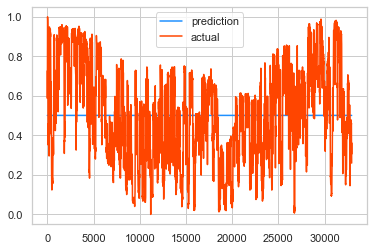

In [9]:
start = 96*21
num = 96*7*52
plt.plot(y_pred[start:num+start],label='prediction',color='dodgerblue')
plt.plot(y_test[start:num+start],label='actual',color='orangered')
plt.legend()
print('RMSE: '+ str(mean_squared_error(y_test, y_pred,squared=False)))
print('MAE: '+ str(mean_absolute_error(y_test,y_pred)))
print('R²: '+ str(r2_score(y_test,y_pred)))